# Search videos using fast.ai

## Overview

We want to find moments when a bicycle appears in a video.

### Transfer learning with a pre-trained model

This notebook assumes you have gone through the steps of the pervious notebook in this folder, `dd-sorting-images-with-fastai`.

## The Plan

The goal is to see if we can spot something specific in a video. This would be useful especially if you had hours of video you didn't have time to watch.

In our case, we'll try to spot bicycles in this video:

Our plan is:

- Download training images sorted into folders labeled "bike" and "nobike"
- Download a computer-vision model pre-trained on 1.2 million images
- Further train that model with our bike/nobike images
- Chop up our video into frames
- Use the model to detect bikes in frames

## Credits

This notebook is based on the early lessons in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course. 

-- John Keefe, [Quartz](https://qz.com), October 2019

## Setup

### For those using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes), or if you use one for more than 12 hours.

If you're using Google Colaboratory, be sure to set your runtime to "GPU" which speeds up your notebook for machine learning:

![change runtime](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/change_runtime_2.jpg)
![pick gpu](https://qz-aistudio-public.s3.amazonaws.com/workshops/notebook_images/pick_gpu_2.jpg)

Then run this cell:

In [1]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### For those _not_ using Google Colaboratory ...

This section is just for people who decide to use one of the notebooks on a system other than Google Colaboartory. 

Those people should run the cell below.

In [0]:
## NON-COLABORATORY USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!sudo apt --yes install ffmpeg

### Everybody do this ...

Everyone needs to run the next cell, which initializes the Python libraries we'll use in this notebook.

In [5]:
## AND *EVERYBODY* SHOULD RUN THIS CELL
import glob
import warnings
warnings.filterwarnings('ignore')
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image as Show
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.59
cuda: True


## The Data

We'll be analyzing a video later, so that's in our data download.

Also in the download are two folders:

- "nobike" has 55 images that don't contain bikes
- "bike" has another 55 images with bikes

_Note that this is an incredibly small data set to work from! Just 110 images total._

Let's get the video and the "bike" and "nobike" images, which are in the folders `bike` and `nobike` respectively.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd /content/drive/'My Drive'/Colab_Notebooks/ml_journalists

In [8]:
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip --quiet
!unzip -q bikes_data.zip
print('Done!')

Done!


Now you have a subdirectory called `bikes_data` which contains two folders (`bike` and `nobike`) and the movie.

In [9]:
%ls bikes_data

images/  intersection_movie.mov  never_seen_image.jpg


In [10]:
%ls bikes_data/images

bike/  nobike/


In [11]:
%ls bikes_data/images/bike

 bikevid010.jpg   IMG_1482.JPG   IMG_1502.JPG   IMG_1524.JPG   IMG_1675.JPG
 bikevid042.jpg   IMG_1483.JPG   IMG_1504.JPG   IMG_1525.JPG   IMG_1678.JPG
 bikevid062.jpg   IMG_1486.JPG   IMG_1505.JPG   IMG_1527.JPG   IMG_1679.JPG
 bikevid080.jpg   IMG_1490.JPG   IMG_1506.JPG   IMG_1528.JPG   IMG_1680.JPG
 bikevid104.jpg   IMG_1491.JPG   IMG_1508.JPG   IMG_1533.JPG   IMG_1682.JPG
 bikevid118.jpg   IMG_1492.JPG   IMG_1510.JPG   IMG_1541.JPG   IMG_1687.JPG
 bikevid120.jpg   IMG_1494.JPG   IMG_1514.JPG   IMG_1547.JPG   IMG_1696.JPG
 bikevid124.jpg   IMG_1497.JPG   IMG_1516.JPG   IMG_1548.JPG  'IMG_1700 2.JPG'
 IMG_1479.JPG     IMG_1498.JPG   IMG_1518.JPG   IMG_1549.JPG   IMG_1702.JPG
 IMG_1480.JPG     IMG_1500.JPG   IMG_1519.JPG   IMG_1553.JPG   IMG_1703.JPG
 IMG_1481.JPG     IMG_1501.JPG   IMG_1520.JPG   IMG_1600.JPG


Let's take a looks at one ...

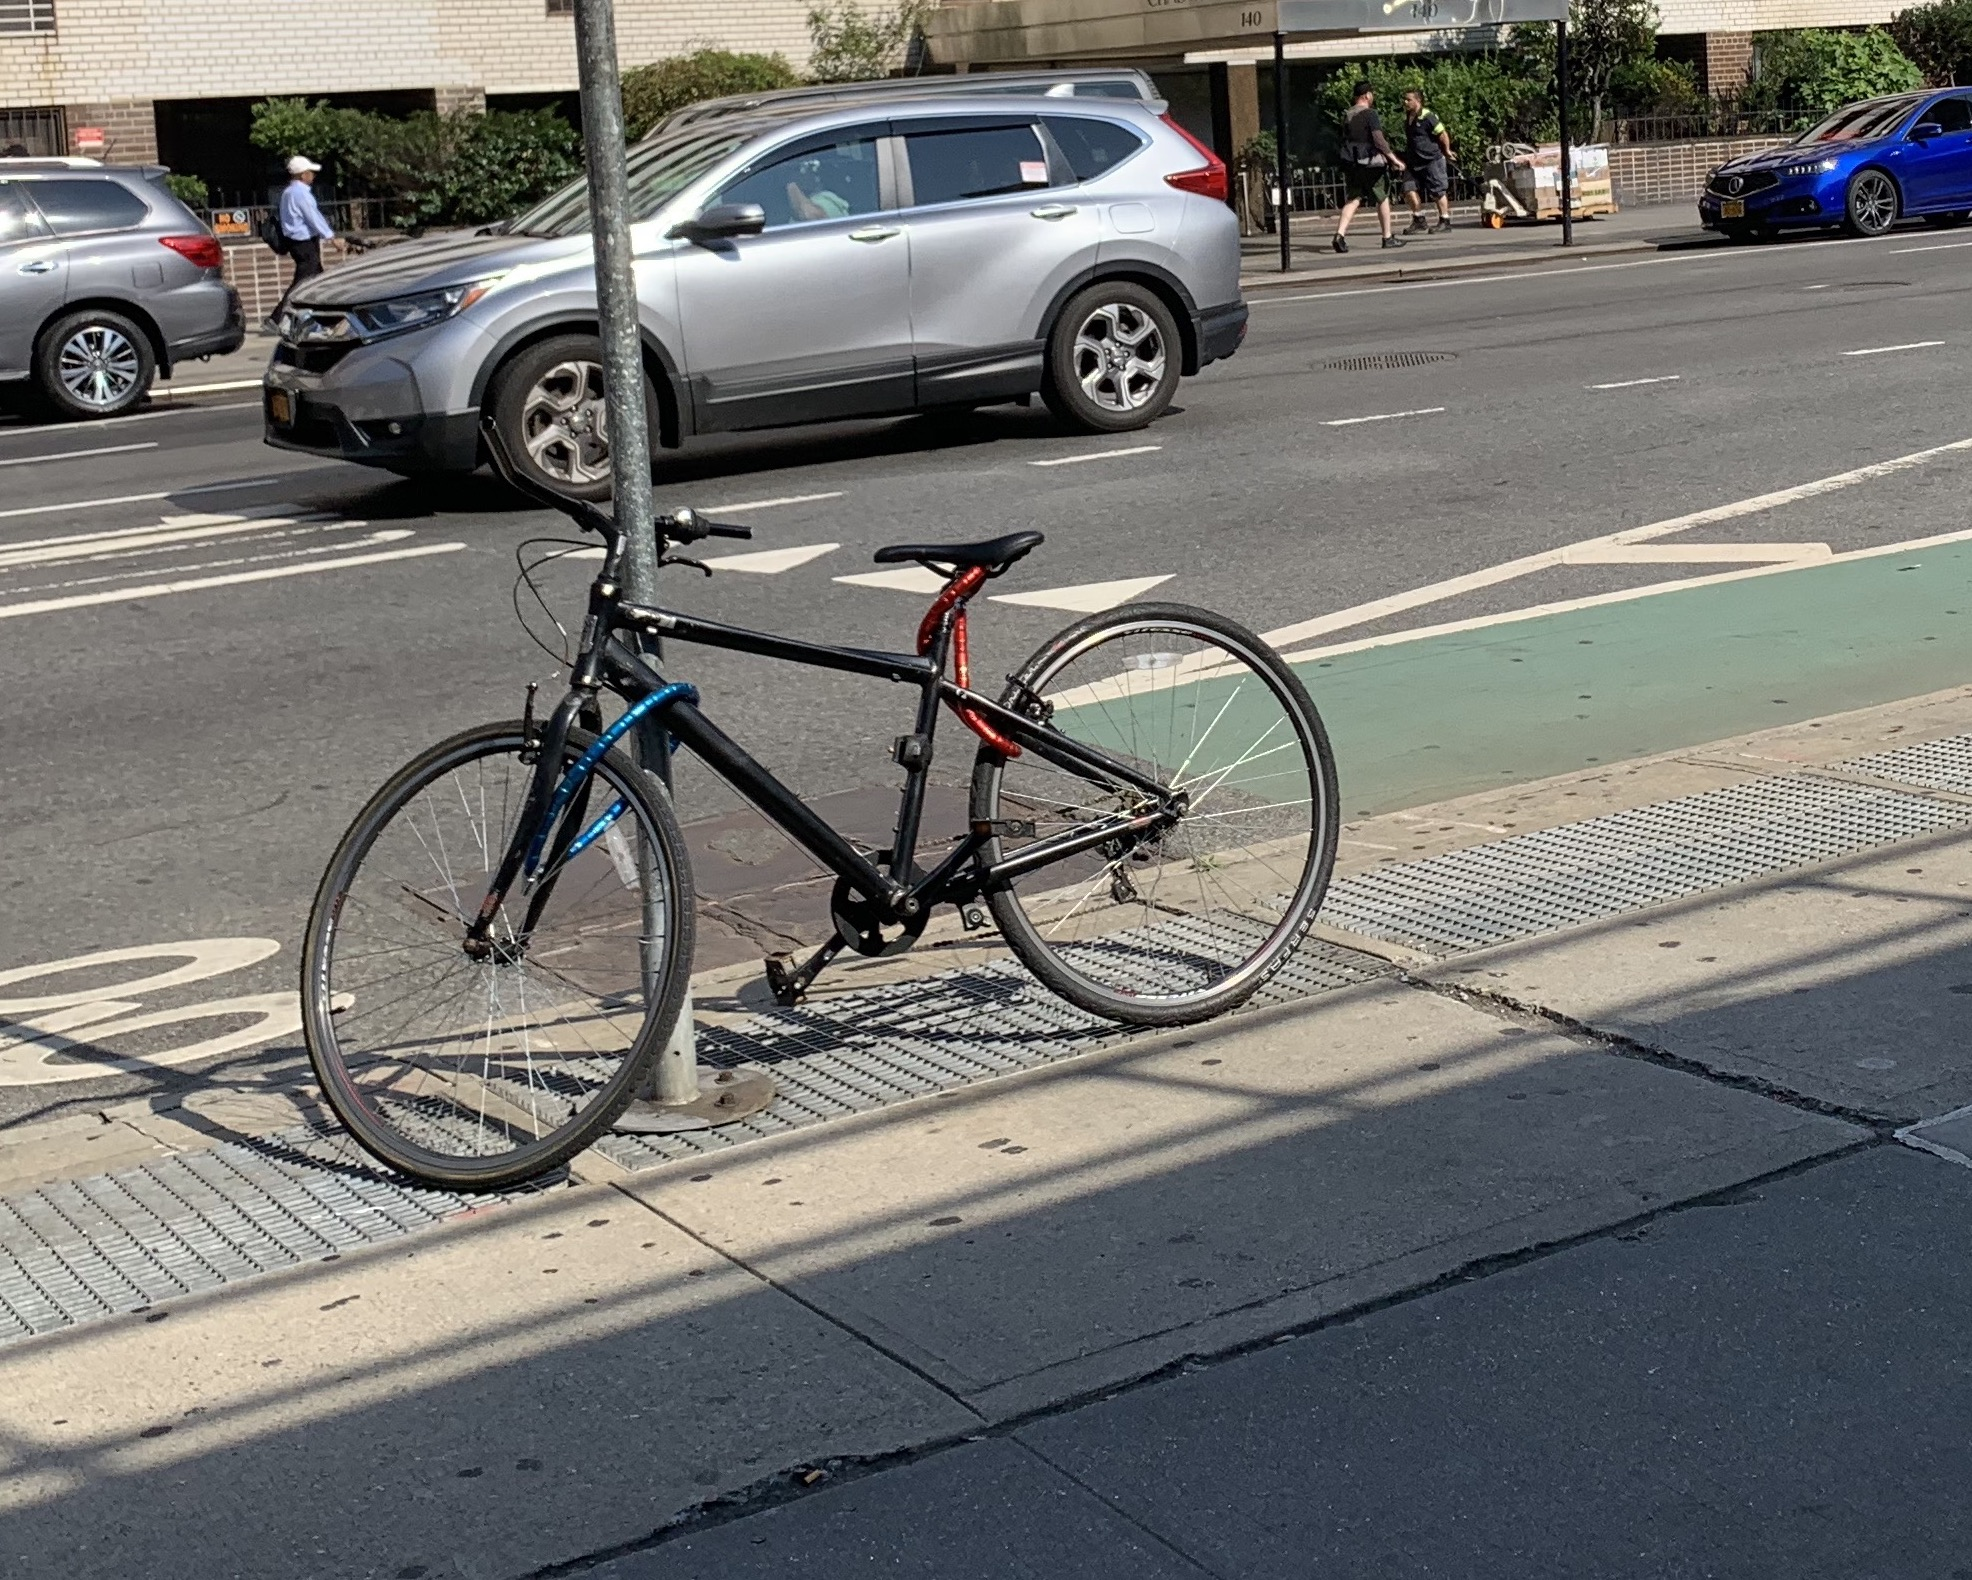

In [12]:
Show(filename='bikes_data/images/bike/IMG_1494.JPG', width=640)

Notebooks aren't great at playing videos, so I posted `bikes_data/intersection_movie.mov` on [Vimeo](https://vimeo.com/354069170).

Now we need to load our image data in a format that's ready for the training code. We do that with fast.ai's data block.

In [0]:
data_path = Path('./bikes_data/images') ## The path for our data

my_transforms = get_transforms() # get_transforms() is the default transform set

data = (ImageList.from_folder(data_path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct() #How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder() #How to label? -> depending on the folder of the filenames
        .transform(my_transforms, size=(224,224)) #Data transforms applied, size of images shrink to 224
        .databunch(bs=48))

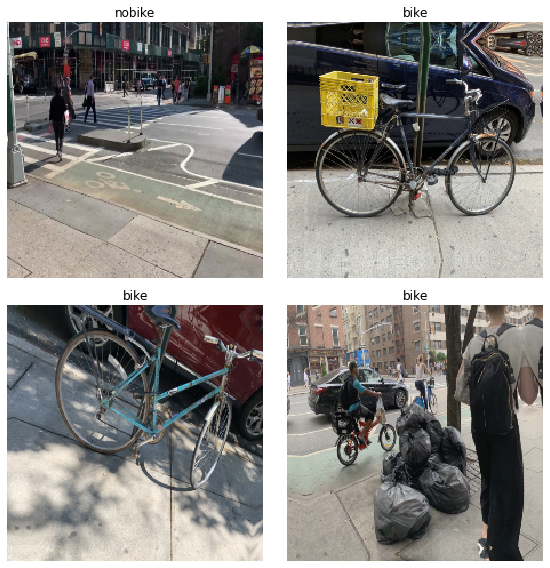

In [15]:
data.show_batch(rows=2)

In [16]:
# Let's be sure to check our classes
print(data.classes)

['bike', 'nobike']


#### Training

Once again, we'll be training a computer-vision model by starting with a pre-trained model called resnet34. With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning."

First we load our `data` and `model.resnet34` together into a training model known as a "learner."

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]


We will train for 6 epochs (6 cycles through all our data).

In [18]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.841662,2.202479,0.523810,00:24
1,1.830508,0.898156,0.380952,00:23
2,1.448963,0.790453,0.285714,00:23
3,1.158433,0.742558,0.190476,00:25
4,0.954103,0.711392,0.190476,00:25
5,0.848198,0.671916,0.190476,00:23


### How are we doing?

So far, we have a pretty good error rate. It's actually possible to do even better, but we'll stick with this for now.

We can take a look to see where the model was most confused, and whether what the model predicted was reasonable or not.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
interp.plot_top_losses(9, heatmap=True)

We can also see the situations in which it was most confused:

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

Let's try a picture we haven't used yet ... not for training, not for validation, not at all.

In [0]:
Show(filename='bikes_data/never_seen_image.jpg', width=640)

In [0]:
img = open_image('bikes_data/never_seen_image.jpg')

In [0]:
pred_class, pred_idx, outputs = learn.predict(img)

In [0]:
pred_class

In [0]:
str(pred_class)

In [0]:
outputs

In [0]:
outputs[0]

## Search our video

Now we'll apply our model to our video! First we need to turn the video into a bunch of images using `ffmpeg`, which we loaded at the beginning of this notebook.

We'll be using a very cool, all-purpose video tool called "[ffmpeg](https://www.ffmpeg.org/)." Check out the [ffmpeg documentation]() for more about all the things it can do, and the commands you can use. I also googled around to figure out the best way to use ffmpeg to split videos into images.

The next, admittedly cryptic command, pulls out a `.jpg` image from the video every second (the `fps` or frames per second is set to `1`). It also names the images using the format "myframe0000.jpg" ... with the four zeros increasing with every frame.

In [0]:
!ffmpeg -i bikes_data/intersection_movie.mov -vf fps=1 -hide_banner -loglevel panic -vsync 0 myframe%04d.jpg

In [0]:
# Let's see what we have
%ls

In [0]:
# get a list of all the "myframe" file names
file_list = sorted(glob.glob('myframe*.*'))

In [0]:
file_list

In [0]:
for file in file_list:
    image = open_image(file)
    pred_class,pred_idx,outputs = learn.predict(image)
        
    if str(pred_class) == "bike" and outputs[0] > 0.85:
        print(f'Bike detected in {file} with confidence {outputs[0]}')
    

In [0]:
Show(filename='myframe0025.jpg', width=640)

## Doing even better

### Transformations

Transformations apply visual fun to the training images to mix things up a bit and help make the model more _generalizable_ -- that is, for example, seeing more kinds of images of bikes than the images we have by changing the lighting, the cropping, the rotation, and the flip of the images. 

There is a really good description of transformations [in this blog post](https://medium.com/@pierre_guillou/data-augmentation-by-fastai-v1-84ca04bea302). The fast.ai transformation documentation is a little harder to follow if you're not a coder, [but it's here](https://docs.fast.ai/vision.transform.html).

### The *get_transforms()* set

We've been using `get_transforms()` to adjust our images so far. That is actually a _set_ of transformations, [detailed here](https://docs.fast.ai/vision.transform.html#get_transforms), which do the following to the training images:

- flip the images horizontally with a 50% chance
- don't flip the images vertically
- rotate the image between -10 and +10 degrees with a 75% chance
- zoom into the image up to 110% with a 75% chance
- change the brightness and contrast by 20% with a 75% chance
- warp the image between -20% and +20% with a chance 75% chance

Those settings have worked well for a wide range of tasks.

These `get_transforms()` defaults are:

```
my_transforms = (get_transforms(
                   do_flip=True, 
                   flip_vert=False,
                   max_rotate=10.0, 
                   max_zoom=1.1, 
                   max_lighting=0.2, 
                   max_warp:float=0.2, 
                   p_affine=0.75, 
                   p_lighting=0.75) )
```

Note that `p_affine` is the probability a zoom or warp will happen, and `p_lighting` is the probability a lighting change will happen.

If you want to **change** these values, say to allow vertical flipping and increase the rotation, you can just declare changes in those parameters:

```
my_transforms = (get_transforms(
                   flip_vert=True,
                   max_rotate=25.0) )
```

You can also **add** transformations to this set:

```
extra_transformations = [
                [zoom_crop(scale=(1.0,1.50), do_rand=False)],  
                [contrast(scale=(0.5,2.0), p=0.75 ] ]

my_transforms = (get_transforms(
                   flip_vert=True,
                   max_rotate=25.0
                   xtra_tfms=extra_tranformations) )
```

Let's modify ours to minimize rotation, since we don't get many images of bikes going uphill dramatically, and add some zoom, since most of our examples are in the middle of the frame.

In [0]:
# using all the get_transforms defaults except a couple which we're changing
my_transforms = (get_transforms(
                   max_rotate=5.0, 
                   max_zoom=2.0) )

### Loading same images as "more" images

The "learn" variable still has all of our trained information – including the structure of the model and the model math, known as "weights." We can add more data to it.

We'll add our new transforms, _and_ we'll change the size of the training images. To the model, these will look like _brand new images it has never seen before_. 

That's because in the training process, our convolutional neural network looks at small groups of pixels at a time. If we use bigger versions of the image, it's still a bike to us, but those clusters of pixels will be _completely new to the computer_.

Just think: Originally we had 224x224 images, each of which which have 50,176 pixels. If we boost that to 512x512, that's 262,144 pixels per image ... and many more small groups to inspect in the process of learning to detect bikes.

In [0]:
# Make a new data bunch, but size the images to 512 pixes square
data2 = (ImageList.from_folder(data_path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct() #How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder() #How to label? -> depending on the folder of the filenames
        .transform(my_transforms, size=(512,512)) #Data transforms applied, size of images shrink to 224
        .databunch(bs=12)) # We lower the batch size so we don't overwhelm the computer

In [0]:
# put this new data into the learner ...
learn.data = data2

In [0]:
# freeze what we've trained before
learn.freeze()

In [0]:
# train some more
learn.fit_one_cycle(5)

So let's analyze the video again, with the new data!

In [0]:
for file in file_list:
    image = open_image(file)
    pred_class,pred_idx,outputs = learn.predict(image)
        
    if str(pred_class) == "bike" and outputs[0] > 0.85:
        print(f'Bike detected in {file} with confidence {outputs[0]}')

Take a close look and you'll see it got _much_ better!

In [0]:
Show(filename='myframe0025.jpg', width=640)

## Saving Models to Google Drive

At present, your Google Colaboratory Notebook disappears when you close it — along with all of your data and the values of the variables we set. That includes the model, which is called `learn`. 

If you'd like to save your model to your Google Drive in a folder called "ai-workshop," run the following cell and grant the permissions it requests.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ai-workshop/bike_video_models/'
save_path = Path(base_dir)
save_path.mkdir(parents=True, exist_ok=True)

The next line will save everything we need for predictions to a file to your Google Drive in the `ai-workshops` folder.

In [0]:
learn.export(save_path/"export.pkl")

Later, to load the model into your code, connect to your Google drive using the same block above that starts `from google.colab import drive ...` and then run this:
    

In [0]:
# load the model from the 'export.pkl' file on your Google Drive
learn = load_learner(save_path)  